# Necessary Imports

In [116]:
# Import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
from torch import nn
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import DataLoader, TensorDataset, random_split
from time import time

In [117]:
import os

# Download The Dataset & Define The Transforms

In [118]:
from torchvision import datasets,transforms


# Đường dẫn đến các file
train_path = 'C:\\Users\\ThanhTan\\Desktop\\nhandienchuviet\\train.csv\\train.csv'
test_path = 'C:\\Users\\ThanhTan\\Desktop\\nhandienchuviet\\test.csv\\test.csv'

# Gán dữ liệu và nhãn từ các file
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)


train_labels = torch.tensor(train_data.iloc[:, 0].values)
train_images = torch.tensor(train_data.iloc[:, 1:].values).float() / 255.0  # Chuẩn hóa
train_images = train_images.reshape(-1, 1, 28, 28)  # Reshape để phù hợp với định dạng (Batch, Channels, Height, Width)


test_images = torch.tensor(test_data.values).float() / 255.0
test_images = test_images.reshape(-1, 1, 28, 28)

print("Train Images Shape:", train_images.shape)  # Mong đợi: [42000, 1, 28, 28]
print("Test Images Shape:", test_images.shape)  # Mong đợi: [28000, 1, 28, 28]

# Tạo TensorDataset với nhãn
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images)

# Chia dữ liệu thành tập huấn luyện và tập validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Tạo DataLoader cho tập huấn luyện và validation
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# In ra kích thước để kiểm tra
print("Train Images Shape:", train_images.shape)
print("Test Images Shape:", test_images.shape)



Train Images Shape: torch.Size([42000, 1, 28, 28])
Test Images Shape: torch.Size([28000, 1, 28, 28])
Train Images Shape: torch.Size([42000, 1, 28, 28])
Test Images Shape: torch.Size([28000, 1, 28, 28])


# Exploring The Data

In [119]:
# Lấy dữ liệu
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


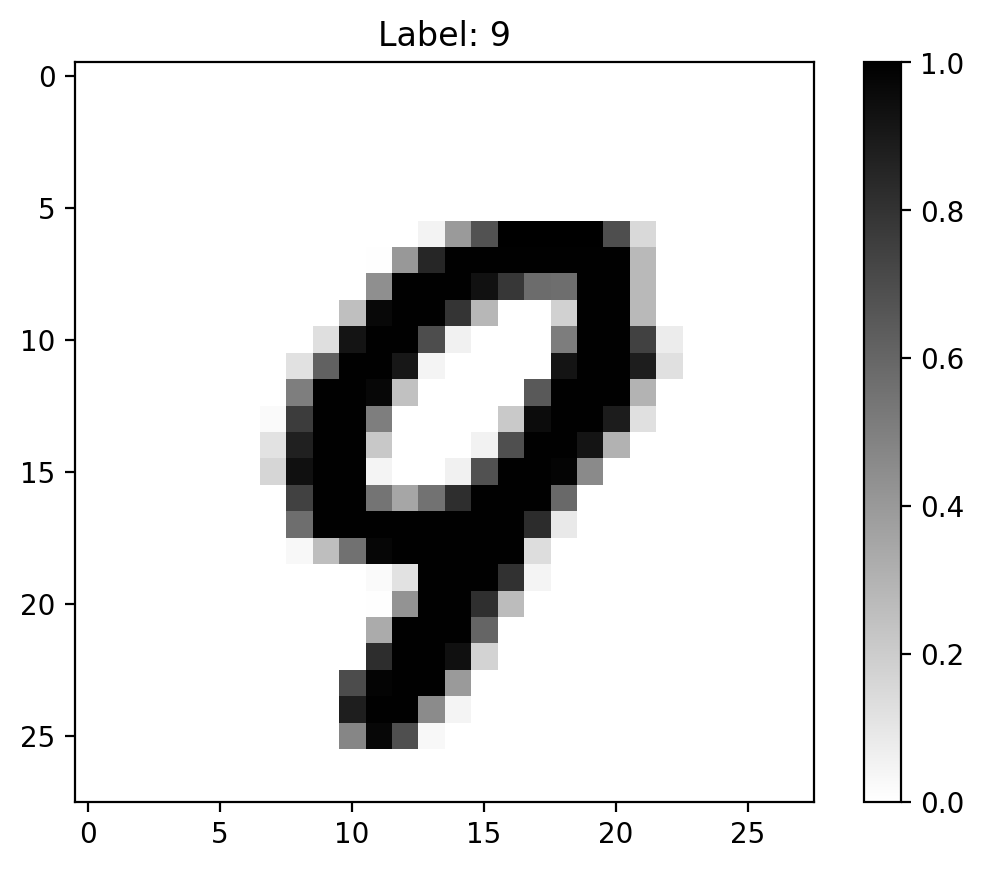

In [120]:
# Hiển thị ảnh đầu tiên và nhãn tương ứng
image = images[0].numpy().squeeze()
label = labels[0].item()
plt.imshow(image, cmap='gray_r')
plt.title(f'Label: {label}')
plt.colorbar()
plt.show()

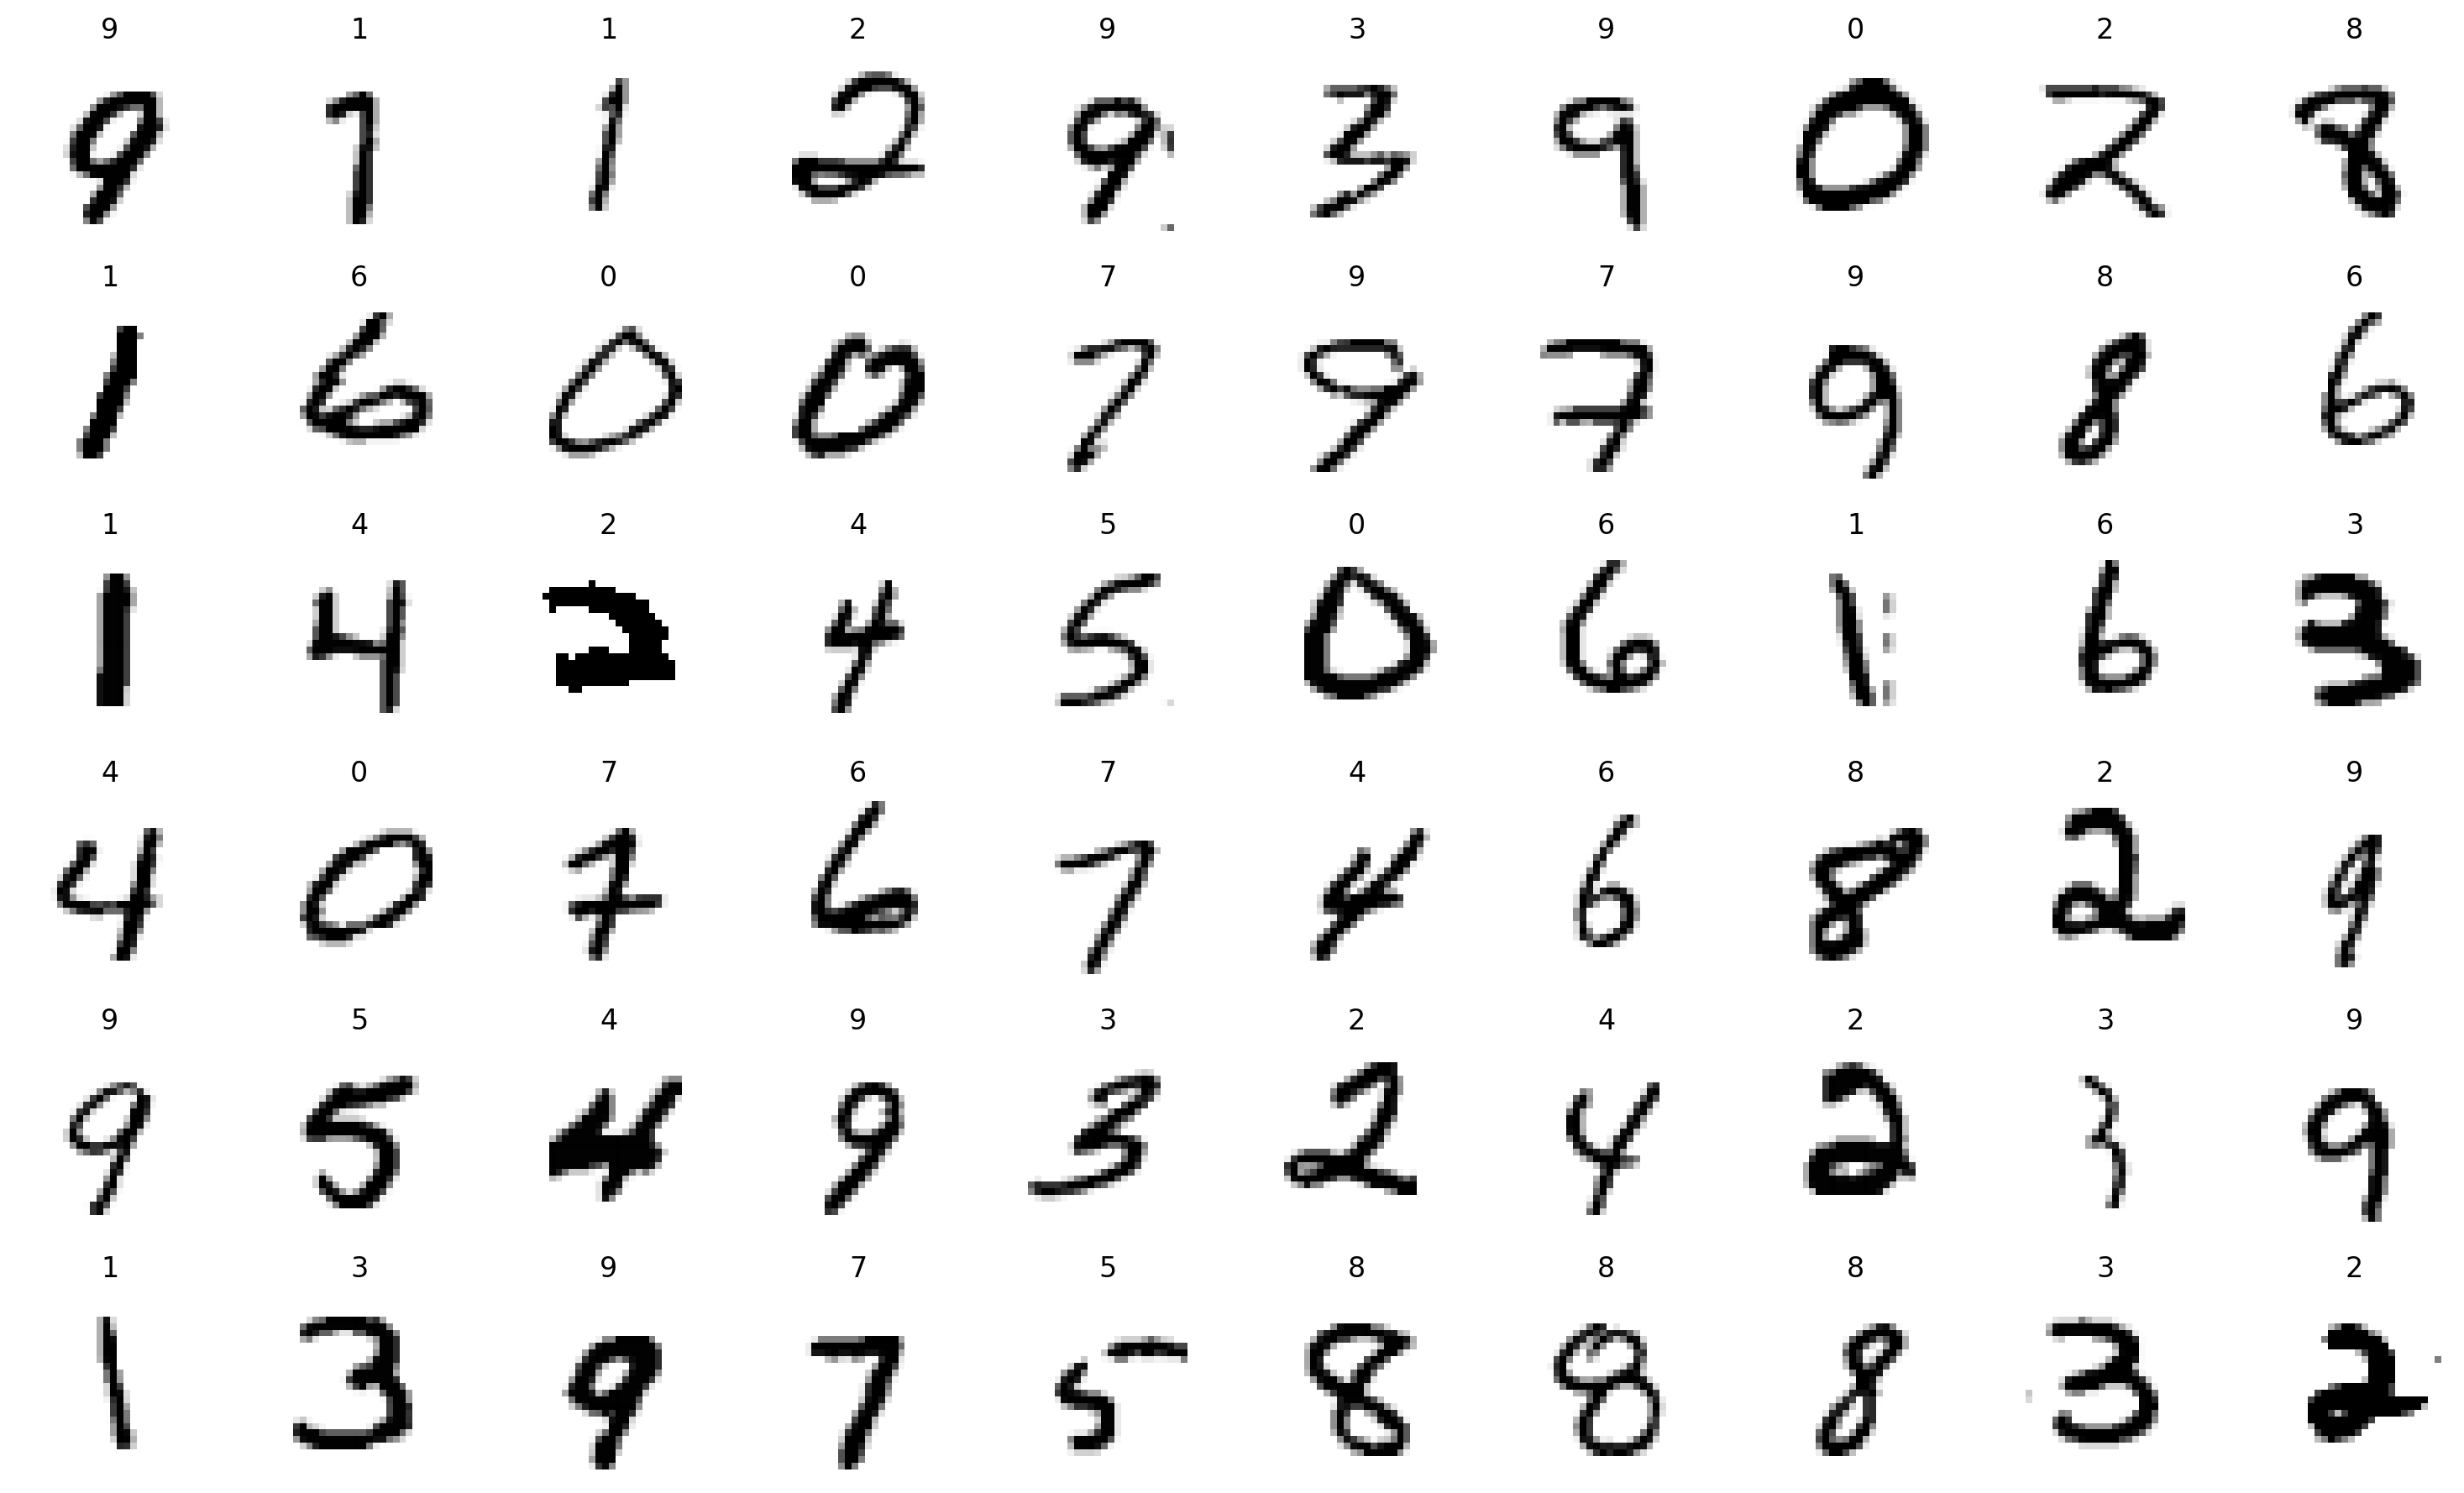

In [121]:
# Hiển thị lưới ảnh
figure, axes = plt.subplots(6, 10, figsize=(15, 9))  # Cấu hình subplot với kích thước phù hợp
axes = axes.flatten()  # Làm phẳng mảng axes để dễ vòng lặp
for idx, ax in enumerate(axes):
    if idx < len(images):  # Kiểm tra để tránh IndexError nếu số ảnh ít hơn 60
        image = images[idx].numpy().squeeze()
        ax.imshow(image, cmap='gray_r')
        ax.axis('off')
        ax.set_title(labels[idx].item())
plt.tight_layout()
plt.show()

# Defining The Neural Network

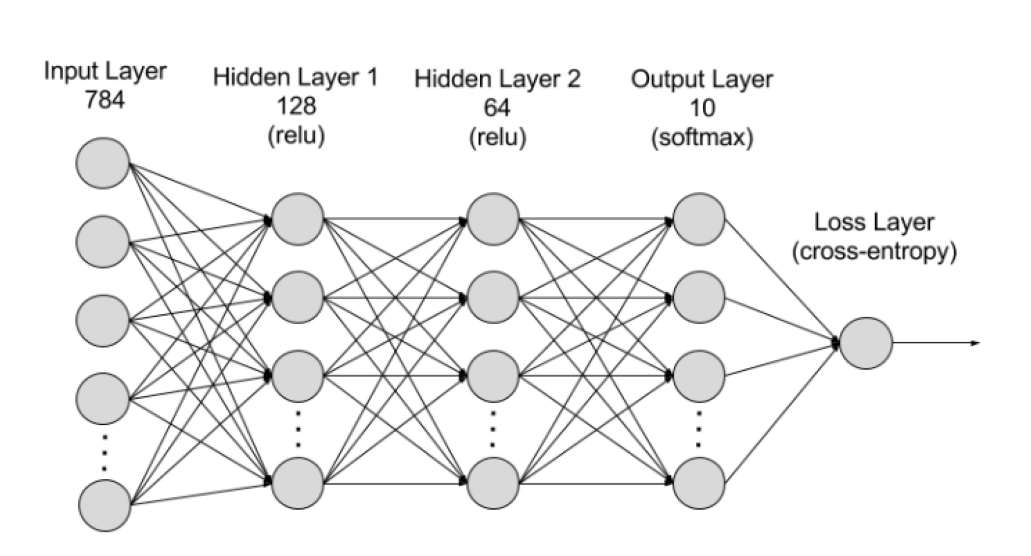

In [122]:
# Đường dẫn tới ảnh
image_path = 'C:\\Users\\ThanhTan\\Desktop\\nhandienchuviet\\DefiningTheNeuralNetwork.png'

# Đọc ảnh
img = mpimg.imread(image_path)

# Hiển thị ảnh
plt.imshow(img)
plt.axis('off')  # Tùy chọn không hiển thị trục
plt.show()

In [123]:
import torch.optim as optim

# Layer details for the neural network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1)
)
# Xác định optimizer và criterion
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

In [124]:
# Tạo một batch dữ liệu ngẫu nhiên và nhãn tương ứng
simple_input = torch.randn(64, 784, requires_grad=True)  # Giả sử batch_size là 64
simple_labels = torch.randint(0, output_size, (64,))  # Tạo nhãn ngẫu nhiên từ 0 đến 9


In [125]:
# Clear gradients (để đảm bảo gradients cũ không ảnh hưởng đến kết quả)
optimizer.zero_grad()

# Thực hiện forward pass
output = model(simple_input)

# Tính loss
loss = criterion(output, simple_labels)

# Backward pass để tính gradient
loss.backward()


In [126]:
# In ra gradient của trọng số trong lớp đầu tiên
print("Gradient of the first layer weights:\n", model[0].weight.grad)


Gradient of the first layer weights:
 tensor([[-1.7557e-03, -4.8455e-04, -4.2286e-03,  ..., -3.9368e-03,
         -1.2604e-03, -2.9440e-03],
        [ 1.0307e-03,  2.0936e-03,  9.1357e-04,  ...,  2.6203e-03,
          1.0268e-03,  3.9313e-03],
        [ 1.1567e-03, -2.1594e-03, -1.4714e-03,  ..., -3.2828e-04,
         -1.6055e-03, -1.9178e-03],
        ...,
        [ 1.2355e-03, -1.4375e-03,  7.6610e-04,  ...,  4.6502e-04,
         -1.1372e-03,  1.7322e-03],
        [-1.4052e-04,  2.0372e-03,  3.2551e-04,  ...,  6.8645e-04,
          1.1895e-03,  2.1264e-03],
        [ 4.3502e-05, -1.4428e-03, -9.5175e-05,  ..., -7.0142e-04,
          1.1453e-03, -2.3227e-03]])


# Training

In [127]:
num_epochs = 30  # Số lượng epochs

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:  # Giả sử bạn đã có train_loader
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        output = model(images)
        
        # Compute loss
        loss = criterion(output, labels)
        
        # Perform backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Accumulate loss
        total_loss += loss.item()

        # Đánh giá mô hình trên tập validation
    model.eval()  # Đặt mô hình ở chế độ đánh giá
    val_loss = 0
    with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ
        for images, labels in val_loader:
            images = images.view(images.shape[0], -1)
            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}')
    


Epoch 1/30, Train Loss: 2.1190326425007413, Validation Loss: 1.6772140418038224
Epoch 2/30, Train Loss: 1.0371205163002015, Validation Loss: 0.6643937193986141
Epoch 3/30, Train Loss: 0.5628619346164522, Validation Loss: 0.4744284069447806
Epoch 4/30, Train Loss: 0.4434744997251601, Validation Loss: 0.4001258540559899
Epoch 5/30, Train Loss: 0.38887090853282386, Validation Loss: 0.3629169881230954
Epoch 6/30, Train Loss: 0.35728435387214025, Validation Loss: 0.3375385781242089
Epoch 7/30, Train Loss: 0.3355022798833393, Validation Loss: 0.32189465870121214
Epoch 8/30, Train Loss: 0.31758733325061345, Validation Loss: 0.3056701347796303
Epoch 9/30, Train Loss: 0.3028839270699592, Validation Loss: 0.29715117611781217
Epoch 10/30, Train Loss: 0.28949525806165877, Validation Loss: 0.2840554836544801
Epoch 11/30, Train Loss: 0.2775915716943287, Validation Loss: 0.2733112504621121
Epoch 12/30, Train Loss: 0.26606933738504135, Validation Loss: 0.26525382538128534
Epoch 13/30, Train Loss: 0.25

Predicted Digit = 5


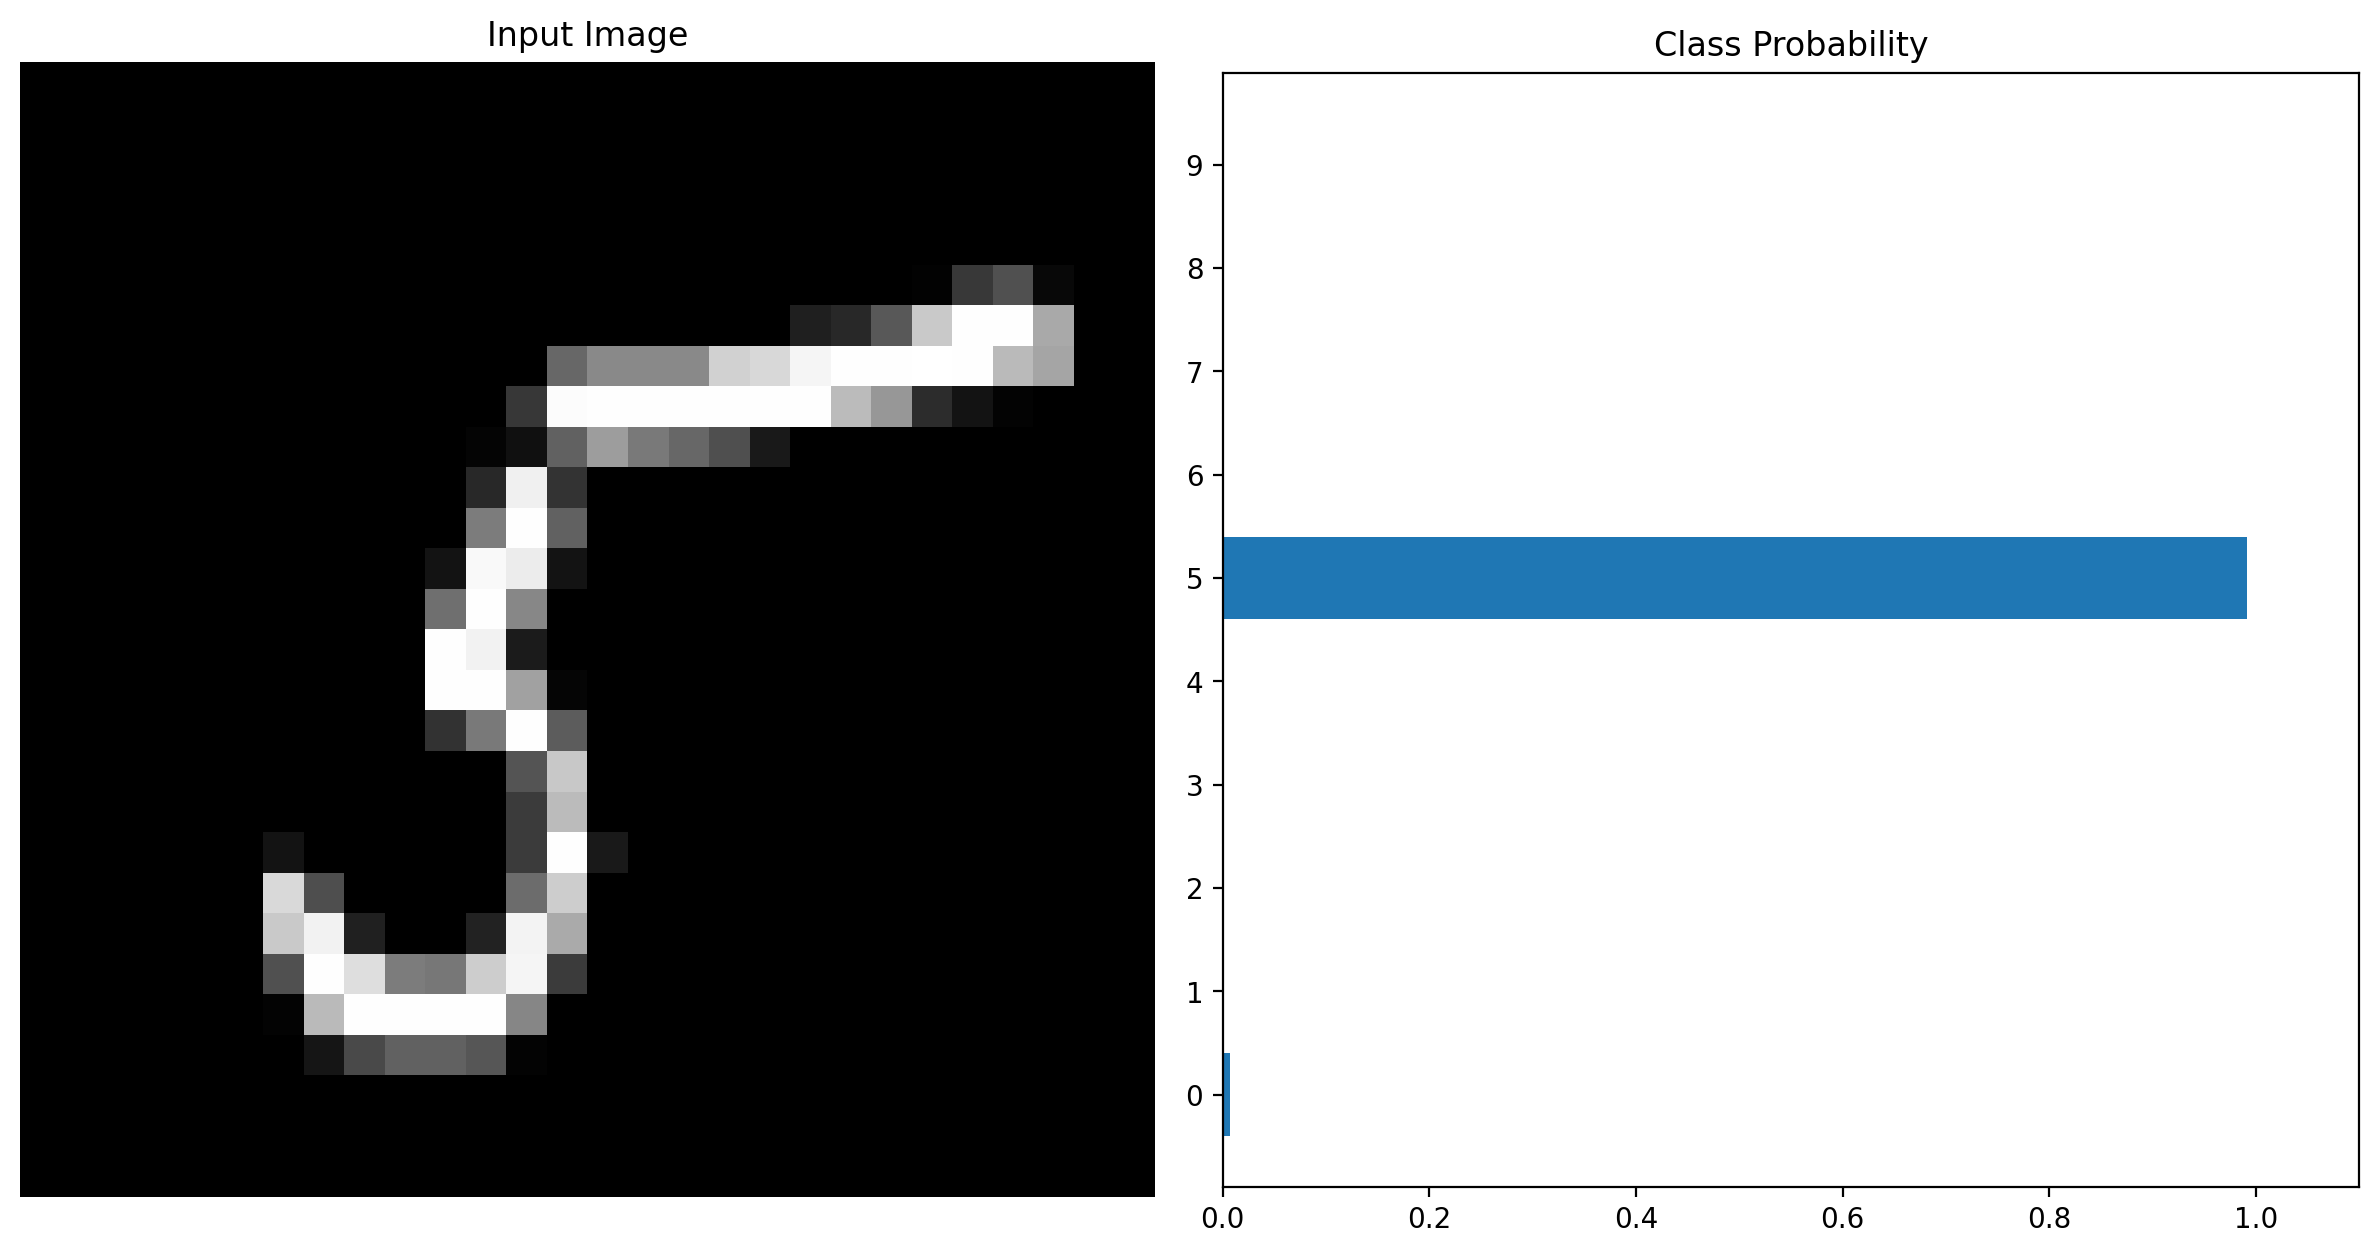

In [144]:
# Lấy một batch ảnh từ test_loader
batch = next(iter(test_loader))
images = batch[0]  # Lấy các ảnh từ batch

# Lấy một ảnh bất kỳ từ batch, ví dụ ảnh thứ 1
img = images[23].view(1, 784)

# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))

# Hiển thị ảnh và dự đoán
def view_classify(img, ps):
    ''' Function for viewing an image and its predicted classes.
    '''
    ps = ps.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), ncols=2)
    ax1.imshow(img.view(28, 28).numpy().squeeze(), cmap='gray')
    ax1.axis('off')
    ax1.set_title('Input Image')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    plt.show()

view_classify(img.view(1, 28, 28), ps)